In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

In [2]:
garstec_data = r'C:\Users\kiena\Documents\YEAR 4\PROJECT\Data\Garstec_AS09_chiara.hdf5'

# Inputs
ages = []
massini = []
fehini = []
alphamlt = []
yini = []
eta = []
alphafe = []

# Outputs
teff = []
luminosity = []

# Open the hdf5 file (read-only mode)
with h5py.File(garstec_data, 'r') as hdf:

    grid = hdf['grid']
    tracks = grid['tracks']

    # Get a list of track names and shuffle for random sampling
    track_names = list(tracks.keys())
    random.shuffle(track_names)

    # Choose a subset of tracks to process
    num_tracks = 1000  # Set the number of tracks to process
    selected_tracks = track_names[:num_tracks]

    for track_name in selected_tracks:  # Iterate over the selected track names
        track = tracks[track_name]
        ages.append(track['age'][:])
        teff.append(track['Teff'][:])
        luminosity.append(track['LPhot'][:])
        massini.append(track['massini'][:])
        fehini.append(track['FeHini'][:])
        alphamlt.append(track['alphaMLT'][:])
        yini.append(track['yini'][:])
        eta.append(track['eta'][:])
        alphafe.append(track['alphaFe'][:])

# Convert lists to numpy arrays and concatenate them (make one big list)
ages = np.concatenate(ages).reshape(-1, 1)
teff = np.concatenate(teff)
luminosity = np.concatenate(luminosity)
massini = np.concatenate(massini).reshape(-1, 1)
fehini = np.concatenate(fehini).reshape(-1, 1)
alphamlt = np.concatenate(alphamlt).reshape(-1, 1)
yini = np.concatenate(yini).reshape(-1, 1)
eta = np.concatenate(eta).reshape(-1, 1)
alphafe = np.concatenate(alphafe).reshape(-1, 1)

# Combine all inputs into a single array
inputs = np.hstack((ages, massini, fehini, alphamlt, yini, eta, alphafe))

# Combine Teff and LPhot as outputs
outputs = np.column_stack((teff, luminosity))



In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train)
y_test_tensor = torch.FloatTensor(y_test)


In [4]:
# Define the neural network
class GarstecNet(nn.Module):
    def __init__(self):
        super(GarstecNet, self).__init__()
        self.dense1 = nn.Linear(7, 64)   # Input layer
        self.bn1 = nn.BatchNorm1d(64)
        self.dense2 = nn.Linear(64, 128)
        self.bn2 = nn.BatchNorm1d(128) 
        self.dense3 = nn.Linear(128, 64)  
        self.bn3 = nn.BatchNorm1d(64) 
        self.dense4 = nn.Linear(64, 2)    # Output layer for luminosity and temperature
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = torch.relu(self.bn1(self.dense1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.dense2(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn3(self.dense3(x)))  
        x = self.dropout(x)
        x = self.dense4(x)
        return x

    
# Instantiate model, loss function, and optimizer
model = GarstecNet()
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Lists to store loss for plotting
train_losses = []
test_losses = []

epochs = 100

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.9)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Store training loss
    train_losses.append(loss.item())

    # Check test loss
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        test_losses.append(test_loss.item())

    # Print progress every 500 epochs
    if (epoch + 1) % 500 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}, LR: {current_lr:.5e}')


Epoch [10/100], Loss: 0.6799, Test Loss: 0.6542, LR: 1.00000e-02
Epoch [20/100], Loss: 0.6572, Test Loss: 0.6480, LR: 1.00000e-02


KeyboardInterrupt: 

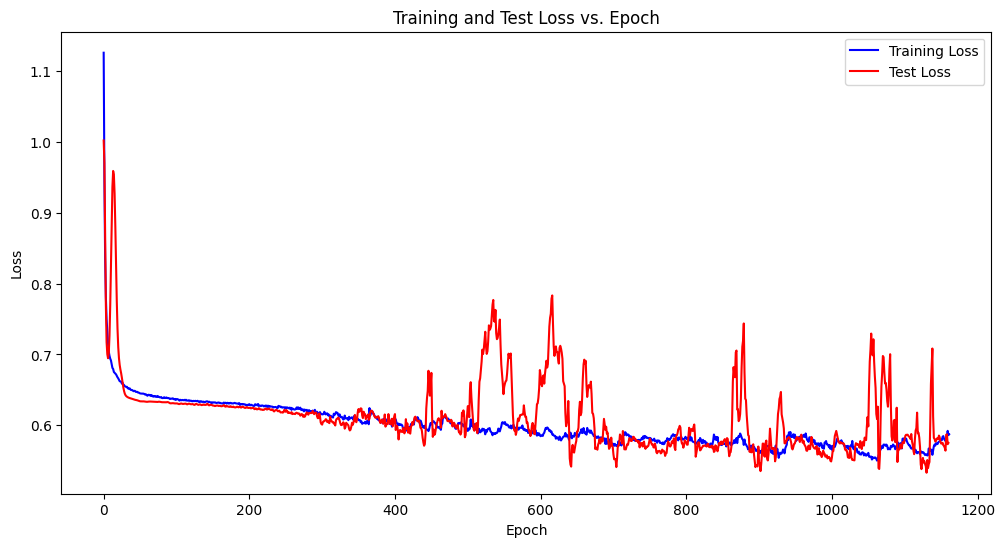

In [ ]:
# Plotting the training and test loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss vs. Epoch')
plt.legend()
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    predictions = scaler_y.inverse_transform(predictions.numpy())
    y_test_actual = scaler_y.inverse_transform(y_test_tensor.numpy())

    # Calculate evaluation metrics
    r2 = r2_score(y_test_actual, predictions)
    mae = mean_absolute_error(y_test_actual, predictions)

    print(f'R^2 Score: {r2:.4f}')
    print(f'Mean Absolute Error: {mae:.4f}')

R^2 Score: -1.5000
Mean Absolute Error: 218.0256


In [ ]:
# Plot predictions for a specific track
specific_track_name = selected_tracks[random.randint(1,9)]  
with h5py.File(garstec_data, 'r') as hdf:
    specific_track = hdf['grid']['tracks'][specific_track_name]
    ages_specific = specific_track['age'][:].reshape(-1, 1)
    teff_specific = specific_track['Teff'][:]
    luminosity_specific = specific_track['LPhot'][:]

# Prepare data for prediction
ages_specific_scaled = scaler_X.transform(ages_specific)
ages_specific_tensor = torch.FloatTensor(ages_specific_scaled)

with torch.no_grad():
    predictions_specific = model(ages_specific_tensor)
    predictions_specific = scaler_y.inverse_transform(predictions_specific.numpy())

# Plot the true and predicted LPhot vs Teff
plt.figure(figsize=(10, 6))
plt.plot(teff_specific, luminosity_specific, label='True Values', color='blue', alpha=0.7)
plt.plot(predictions_specific[:, 0], predictions_specific[:, 1], label='Predicted Values', color='red', linestyle='--', alpha=0.7)
plt.title(f'LPhot vs Teff for Track: {specific_track_name}')
plt.gca().invert_xaxis()
plt.xlabel('Teff')
plt.ylabel('LPhot')
plt.legend()
plt.show()

ValueError: X has 1 features, but StandardScaler is expecting 7 features as input.